In [6]:
# RUN THIS CELL ONCE AT THE TOP OF THE NOTEBOOK

import sys, subprocess, importlib

def ensure(pkgs):
    for p in pkgs:
        try:
            importlib.import_module(p if p != "pyarrow" else "pyarrow")
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", p])

ensure(["pandas", "pyarrow", "fastparquet"])

import os
import pandas as pd
from pathlib import Path

pd.set_option("display.max_columns", 120)

# Fixed paths for your machine
INPUT_DIR  = Path(r"C:\Users\sarve\Downloads\Final_Project_hospital_app\MIMIC-III")
OUTPUT_DIR = Path(r"C:\Users\sarve\Downloads\Final_Project_hospital_app\processed\mimic")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def _read(path, usecols=None, dtype=None, parse_dates=None):
    """
    Robust reader for .csv or .csv.gz with pandas; returns DataFrame.
    """
    path = Path(path)
    if not path.exists():
        alt = Path(str(path) + ".gz")
        if alt.exists():
            path = alt
    return pd.read_csv(path, usecols=usecols, dtype=dtype,
                       parse_dates=parse_dates, low_memory=False)

def _to_parquet(df, out_path):
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_parquet(out_path, index=False)
    print(f"Saved {len(df):,} rows → {out_path}")

def _parse_dt(series):
    return pd.to_datetime(series, errors="coerce", utc=False, infer_datetime_format=True)

def _norm_string(s):
    return (s.astype(str)
             .str.strip()
             .str.replace(r"\s+", " ", regex=True)
             .replace({"nan": None, "None": None}))


In [7]:
usecols = ["row_id","subject_id","gender","dob","dod","dod_hosp","dod_ssn","expire_flag"]
df = _read(INPUT_DIR/"PATIENTS.csv", usecols=usecols)

df["subject_id"] = df["subject_id"].astype("int32")
df["gender"] = df["gender"].str.upper().str.strip().replace({"U": "UNKNOWN"})
for col in ["dob","dod","dod_hosp","dod_ssn"]:
    df[col] = _parse_dt(df[col])
if "expire_flag" in df:
    df["expire_flag"] = df["expire_flag"].fillna(0).astype("int8")

df = df.drop_duplicates(subset=["subject_id"]).sort_values("subject_id").reset_index(drop=True)
_to_parquet(df, OUTPUT_DIR/"patients.parquet")
df.head()


Saved 100 rows → C:\Users\sarve\Downloads\Final_Project_hospital_app\processed\mimic\patients.parquet


C:\Users\sarve\AppData\Local\Temp\ipykernel_12860\1026546342.py:44: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(series, errors="coerce", utc=False, infer_datetime_format=True)
C:\Users\sarve\AppData\Local\Temp\ipykernel_12860\1026546342.py:44: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(series, errors="coerce", utc=False, infer_datetime_format=True)
C:\Users\sarve\AppData\Local\Temp\ipykernel_12860\1026546342.py:44: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a futur

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,9467,10006,F,2094-05-03,2165-12-08,2165-12-08,2165-12-08,1
1,9472,10011,F,2090-05-06,NaT,NaT,NaT,1
2,9474,10013,F,2038-03-09,2125-07-10,2125-07-10,2125-07-10,1
3,9478,10017,F,NaT,2152-12-09,NaT,2152-12-09,1
4,9479,10019,M,NaT,NaT,NaT,NaT,1


In [8]:
usecols = [
    "row_id","subject_id","hadm_id","admittime","dischtime","deathtime",
    "admission_type","admission_location","discharge_location",
    "insurance","language","religion","marital_status","ethnicity",
    "edregtime","edouttime","diagnosis","hospital_expire_flag","has_chartevents_data"
]
df = _read(INPUT_DIR/"ADMISSIONS.csv", usecols=usecols)

for c in ["subject_id","hadm_id","hospital_expire_flag","has_chartevents_data"]:
    if c in df: df[c] = df[c].fillna(0).astype("int32")

for c in ["admittime","dischtime","deathtime","edregtime","edouttime"]:
    if c in df: df[c] = _parse_dt(df[c])

for c in ["admission_type","admission_location","discharge_location",
          "insurance","language","religion","marital_status","ethnicity","diagnosis"]:
    if c in df: df[c] = _norm_string(df[c]).str.upper()

df["los_days"] = ((df["dischtime"] - df["admittime"]).dt.total_seconds()/86400.0).round(4)
df.loc[(df["los_days"] < 0) | (df["los_days"] > 365*2), "los_days"] = pd.NA

df = df.drop_duplicates(subset=["hadm_id"]).sort_values(["subject_id","hadm_id"]).reset_index(drop=True)
_to_parquet(df, OUTPUT_DIR/"admissions.parquet")
df.head()


Saved 129 rows → C:\Users\sarve\Downloads\Final_Project_hospital_app\processed\mimic\admissions.parquet


C:\Users\sarve\AppData\Local\Temp\ipykernel_12860\1026546342.py:44: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(series, errors="coerce", utc=False, infer_datetime_format=True)
C:\Users\sarve\AppData\Local\Temp\ipykernel_12860\1026546342.py:44: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(series, errors="coerce", utc=False, infer_datetime_format=True)
C:\Users\sarve\AppData\Local\Temp\ipykernel_12860\1026546342.py:44: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-c

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,los_days
0,12258,10006,142345,2164-10-23 21:09:00,2164-01-11 17:15:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,MEDICARE,None,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1,NaN
1,12263,10011,105331,2126-08-14 22:32:00,NaT,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,PRIVATE,None,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaT,NaT,HEPATITIS B,1,1,NaN
2,12265,10013,165520,2125-10-04 23:36:00,2125-07-10 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,MEDICARE,None,CATHOLIC,None,UNKNOWN/NOT SPECIFIED,NaT,NaT,SEPSIS,1,1,NaN
3,12269,10017,199207,2149-05-26 17:19:00,2149-03-06 18:42:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,MEDICARE,None,CATHOLIC,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1,NaN
4,12270,10019,177759,2163-05-14 20:43:00,NaT,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,MEDICARE,None,CATHOLIC,DIVORCED,WHITE,NaT,NaT,ALCOHOLIC HEPATITIS,1,1,NaN


In [9]:
usecols = [
    "row_id","subject_id","hadm_id","icustay_id","dbsource",
    "first_careunit","last_careunit","first_wardid","last_wardid",
    "intime","outtime","los"
]
df = _read(INPUT_DIR/"ICUSTAYS.csv", usecols=usecols)

for c in ["subject_id","hadm_id","icustay_id","first_wardid","last_wardid"]:
    if c in df: df[c] = df[c].astype("int32")
for c in ["intime","outtime"]:
    df[c] = _parse_dt(df[c])

df["icu_los_days"] = ((df["outtime"] - df["intime"]).dt.total_seconds()/86400.0).round(4)
df.loc[(df["icu_los_days"] < 0) | (df["icu_los_days"] > 365), "icu_los_days"] = pd.NA

for c in ["dbsource","first_careunit","last_careunit"]:
    if c in df: df[c] = _norm_string(df[c]).str.upper()

df = df.drop_duplicates(subset=["icustay_id"]).sort_values(["subject_id","hadm_id","icustay_id"]).reset_index(drop=True)
_to_parquet(df, OUTPUT_DIR/"icustays.parquet")
df.head()


Saved 136 rows → C:\Users\sarve\Downloads\Final_Project_hospital_app\processed\mimic\icustays.parquet


C:\Users\sarve\AppData\Local\Temp\ipykernel_12860\1026546342.py:44: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(series, errors="coerce", utc=False, infer_datetime_format=True)
C:\Users\sarve\AppData\Local\Temp\ipykernel_12860\1026546342.py:44: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(series, errors="coerce", utc=False, infer_datetime_format=True)
C:\Users\sarve\AppData\Local\Temp\ipykernel_12860\1026546342.py:44: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-c

,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los,icu_los_days
0,12742,10006,142345,206504,CAREVUE,MICU,MICU,52,52,2164-10-23 21:10:00,2164-10-25 12:21:00,1.6325,1.6326
1,12747,10011,105331,232110,CAREVUE,MICU,MICU,15,15,2126-08-14 22:34:00,2126-08-28 18:59:00,13.8507,13.8507
2,12749,10013,165520,264446,CAREVUE,MICU,MICU,15,15,2125-10-04 23:38:00,2125-10-07 15:13:00,2.6499,2.6493
3,12754,10017,199207,204881,CAREVUE,CCU,CCU,7,7,2149-05-29 18:52:00,2149-05-31 22:19:00,2.1436,2.1438
4,12755,10019,177759,228977,CAREVUE,MICU,MICU,15,15,2163-05-14 20:43:00,2163-05-16 03:47:00,1.2938,1.2944


In [10]:
usecols = ["row_id","subject_id","hadm_id","seq_num","icd9_code"]
df = _read(INPUT_DIR/"DIAGNOSES_ICD.csv", usecols=usecols)

df["subject_id"] = df["subject_id"].astype("int32")
df["hadm_id"] = df["hadm_id"].astype("int32")
df["seq_num"] = pd.to_numeric(df["seq_num"], errors="coerce").astype("Int16")

df["icd9_code"] = (
    _norm_string(df["icd9_code"]).str.upper().str.replace(".", "", regex=False)
)

df = df.dropna(subset=["hadm_id","icd9_code"])
df = df.drop_duplicates(subset=["hadm_id","icd9_code","seq_num"]).sort_values(["hadm_id","seq_num"]).reset_index(drop=True)
_to_parquet(df, OUTPUT_DIR/"diagnoses_icd.parquet")
df.head()


Saved 1,761 rows → C:\Users\sarve\Downloads\Final_Project_hospital_app\processed\mimic\diagnoses_icd.parquet


,row_id,subject_id,hadm_id,seq_num,icd9_code
0,112771,10056,100375,1,389
1,112772,10056,100375,2,5990
2,112773,10056,100375,3,5845
3,112774,10056,100375,4,2765
4,112775,10056,100375,5,78552


In [11]:
usecols = ["row_id","itemid","label","fluid","category","loinc_code"]
df = _read(INPUT_DIR/"D_LABITEMS.csv", usecols=usecols)

df["itemid"] = df["itemid"].astype("int32")
for c in ["label","fluid","category","loinc_code"]:
    if c in df: df[c] = _norm_string(df[c]).str.upper()

df = df.drop_duplicates(subset=["itemid"]).sort_values("itemid").reset_index(drop=True)
_to_parquet(df, OUTPUT_DIR/"d_labitems.parquet")
df.head()


Saved 753 rows → C:\Users\sarve\Downloads\Final_Project_hospital_app\processed\mimic\d_labitems.parquet


,row_id,itemid,label,fluid,category,loinc_code
0,1,50800,SPECIMEN TYPE,BLOOD,BLOOD GAS,None
1,2,50801,ALVEOLAR-ARTERIAL GRADIENT,BLOOD,BLOOD GAS,19991-9
2,3,50802,BASE EXCESS,BLOOD,BLOOD GAS,11555-0
3,4,50803,"CALCULATED BICARBONATE, WHOLE BLOOD",BLOOD,BLOOD GAS,1959-6
4,5,50804,CALCULATED TOTAL CO2,BLOOD,BLOOD GAS,34728-6


In [12]:
# Optional but helpful when selecting vital ITEMIDs for CHARTEVENTS.
usecols = ["row_id","itemid","label","dbsource","linksto","category","unitname"]
df = _read(INPUT_DIR/"D_ITEMS.csv", usecols=usecols)

df["itemid"] = df["itemid"].astype("int32")
for c in ["label","dbsource","linksto","category","unitname"]:
    if c in df: df[c] = _norm_string(df[c]).str.upper()

df = df.drop_duplicates(subset=["itemid"]).sort_values("itemid").reset_index(drop=True)
_to_parquet(df, OUTPUT_DIR/"d_items.parquet")
df.head()


Saved 12,487 rows → C:\Users\sarve\Downloads\Final_Project_hospital_app\processed\mimic\d_items.parquet


,row_id,itemid,label,dbsource,linksto,category,unitname
0,27,1,% INSPIR. TIME,CAREVUE,CHARTEVENTS,None,None
1,28,2,ABI (L),CAREVUE,CHARTEVENTS,None,None
2,29,3,ABI (R),CAREVUE,CHARTEVENTS,None,None
3,30,4,ABI ANKLE BP [RIGHT],CAREVUE,CHARTEVENTS,None,None
4,31,5,ABI BRACHIAL BP [RIGHT],CAREVUE,CHARTEVENTS,None,None


In [13]:
src = INPUT_DIR/"LABEVENTS.csv"
out_dir = OUTPUT_DIR/"labevents_parts"
out_dir.mkdir(parents=True, exist_ok=True)

usecols = ["subject_id","hadm_id","itemid","charttime","value","valuenum","valueuom","flag"]
dtype = {"subject_id":"int32","hadm_id":"Int32","itemid":"int32",
         "value":"string","valueuom":"string","flag":"string"}
chunksize = 1_000_000
part = 0

reader_path = src if src.exists() else Path(str(src)+".gz")
for chunk in pd.read_csv(reader_path, usecols=usecols, dtype=dtype,
                         chunksize=chunksize, low_memory=False):
    chunk["charttime"] = _parse_dt(chunk["charttime"])
    chunk["valuenum"]  = pd.to_numeric(chunk["valuenum"], errors="coerce")
    for c in ["value","valueuom","flag"]:
        chunk[c] = _norm_string(chunk[c]).str.upper()

    # drop rows with both numeric and text missing
    chunk = chunk.dropna(subset=["valuenum"], how="all")
    # basic sanity on numeric range
    chunk.loc[(chunk["valuenum"]<-1e6)|(chunk["valuenum"]>1e6), "valuenum"] = pd.NA
    # must have itemid + time
    chunk = chunk.dropna(subset=["itemid","charttime"])

    part += 1
    out_path = out_dir/f"part-{part:05d}.parquet"
    chunk.to_parquet(out_path, index=False)
    print(f"Saved {out_path.name} with {len(chunk):,} rows")

print("LABEVENTS cleaning complete →", out_dir)


C:\Users\sarve\AppData\Local\Temp\ipykernel_12860\1026546342.py:44: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(series, errors="coerce", utc=False, infer_datetime_format=True)


Saved part-00001.parquet with 67,030 rows
LABEVENTS cleaning complete → C:\Users\sarve\Downloads\Final_Project_hospital_app\processed\mimic\labevents_parts


In [14]:
src = INPUT_DIR/"CHARTEVENTS.csv"
out_dir = OUTPUT_DIR/"chartevents_parts"
out_dir.mkdir(parents=True, exist_ok=True)

usecols = ["subject_id","hadm_id","icustay_id","itemid","charttime","value","valuenum","valueuom"]
dtype = {"subject_id":"int32","hadm_id":"Int32","icustay_id":"Int32","itemid":"int32",
         "value":"string","valueuom":"string"}
chunksize = 1_000_000
part = 0

reader_path = src if src.exists() else Path(str(src)+".gz")
for chunk in pd.read_csv(reader_path, usecols=usecols, dtype=dtype,
                         chunksize=chunksize, low_memory=False):
    chunk["charttime"] = _parse_dt(chunk["charttime"])
    chunk["valuenum"]  = pd.to_numeric(chunk["valuenum"], errors="coerce")
    for c in ["value","valueuom"]:
        chunk[c] = _norm_string(chunk[c]).str.upper()

    # drop rows with no measurement at all
    chunk = chunk.dropna(subset=["valuenum","value"], how="all")
    chunk = chunk.dropna(subset=["itemid","charttime"])

    part += 1
    out_path = out_dir/f"part-{part:05d}.parquet"
    chunk.to_parquet(out_path, index=False)
    print(f"Saved {out_path.name} with {len(chunk):,} rows")

print("CHARTEVENTS cleaning complete →", out_dir)


C:\Users\sarve\AppData\Local\Temp\ipykernel_12860\1026546342.py:44: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(series, errors="coerce", utc=False, infer_datetime_format=True)


Saved part-00001.parquet with 283,909 rows
CHARTEVENTS cleaning complete → C:\Users\sarve\Downloads\Final_Project_hospital_app\processed\mimic\chartevents_parts


In [15]:
%pip install --quiet pandas scikit-learn pyarrow


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: C:\Users\sarve\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, average_precision_score, f1_score,
                             confusion_matrix, classification_report,
                             mean_absolute_error, r2_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_DIR = Path(r"C:\Users\sarve\Downloads\Final_Project_hospital_app\processed\mimic")
assert DATA_DIR.exists(), "Processed parquet folder not found"


In [2]:
# Load cleaned tables
patients   = pd.read_parquet(DATA_DIR/"patients.parquet")
admissions = pd.read_parquet(DATA_DIR/"admissions.parquet")
icustays   = pd.read_parquet(DATA_DIR/"icustays.parquet")
dx         = pd.read_parquet(DATA_DIR/"diagnoses_icd.parquet")

# --- Cohort: first ICU stay per (subject, hadm)
icu_first = (icustays.sort_values(["subject_id","hadm_id","intime"])
                      .groupby(["subject_id","hadm_id"], as_index=False).first())

cohort = (icu_first
          .merge(admissions, on=["subject_id","hadm_id"], how="inner", suffixes=("","_adm"))
          .merge(patients[["subject_id","gender","dob"]], on="subject_id", how="left"))

# Age at admission (cap at 89 per HIPAA quirk)
cohort["age"] = ((cohort["admittime"] - cohort["dob"]).dt.days / 365.25).clip(lower=0, upper=89).round(1)

# Targets
cohort["label_mortality"] = cohort["hospital_expire_flag"].fillna(0).astype(int)
cohort["target_los_days"] = cohort["los_days"].astype(float)

# --- Light comorbidity indicators from ICD-9 prefixes (per admission)
dx["icd9_root3"] = dx["icd9_code"].astype(str).str.replace(r"[^A-Z0-9]", "", regex=True).str[:3]

# Map a few common conditions (you can add more later)
cond_map = {
    "DIABETES":   ["250"],         # diabetes mellitus
    "HYPERTEN":   ["401","402","403","404","405"],  # hypertension
    "CHF":        ["428"],         # heart failure
    "CAD":        ["414"],         # coronary atherosclerosis
    "RENALFAIL":  ["584"],         # acute renal failure
    "PNEUMONIA":  ["486"],         # pneumonia
    "COPD":       ["496"],         # chronic airway obstruction
    "SEPSIS":     ["995","785"]    # sepsis/systemic inflammation approx
}

dx_flags = (dx.groupby(["hadm_id","icd9_root3"])
              .size().reset_index(name="n"))

for name, roots in cond_map.items():
    dx_flags[name] = dx_flags["icd9_root3"].isin(roots).astype(int)

dx_agg = (dx_flags.groupby("hadm_id")[list(cond_map.keys())]
                  .max().reset_index())
dx_agg["N_DIAGNOSES"] = (dx.groupby("hadm_id")
                           .size().rename("N_DIAGNOSES").reset_index()["N_DIAGNOSES"].values)

cohort = cohort.merge(dx_agg, on="hadm_id", how="left")
cohort[list(cond_map.keys())] = cohort[list(cond_map.keys())].fillna(0).astype(int)
cohort["N_DIAGNOSES"] = cohort["N_DIAGNOSES"].fillna(0).astype(int)

# Basic filters: adults, valid LOS
cohort = cohort[(cohort["age"] >= 18) & (cohort["age"] <= 89)]
cohort = cohort[cohort["target_los_days"].notna() & (cohort["target_los_days"] >= 0)]

# Select features
feat_cols_num = ["age","icu_los_days","N_DIAGNOSES"]  # NOTE: icu_los_days is the *ICU* length already known during stay; OK for mortality; DO NOT use it for LOS regression
feat_cols_num += list(cond_map.keys())

feat_cols_cat = ["gender","admission_type","admission_location","discharge_location","ethnicity","first_careunit"]

keep_cols = ["subject_id","hadm_id","icustay_id","admittime","dischtime","intime","outtime",
             "label_mortality","target_los_days"] + feat_cols_num + feat_cols_cat

X = cohort[keep_cols].copy()

print("Cohort rows:", len(X))
X.head()


Cohort rows: 7


,subject_id,hadm_id,icustay_id,admittime,dischtime,intime,outtime,label_mortality,target_los_days,age,...,RENALFAIL,PNEUMONIA,COPD,SEPSIS,gender,admission_type,admission_location,discharge_location,ethnicity,first_careunit
16,10044,124073,270154,2152-10-02 16:24:00,2152-11-10 15:42:00,2152-10-03 02:02:00,2152-10-07 16:52:00,0,38.9708,80.9,...,0,0,0,0,F,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,UNKNOWN/NOT SPECIFIED,MICU
31,10088,168233,249695,2107-01-29 04:00:00,2107-10-02 12:00:00,2107-01-29 04:02:00,2107-01-30 18:58:00,0,246.3333,77.4,...,1,0,0,0,M,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,WHITE,CCU
32,10088,169938,256345,2107-01-04 11:59:00,2107-11-01 15:45:00,2107-01-05 00:03:00,2107-01-08 16:35:00,0,301.1569,77.3,...,0,0,0,1,M,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,WHITE,MICU
47,10117,187023,214861,2138-06-05 17:23:00,2138-11-06 10:16:00,2138-06-05 20:16:00,2138-06-07 15:08:00,0,153.7035,66.1,...,0,0,0,0,F,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,UNKNOWN/NOT SPECIFIED,MICU
57,40124,126179,279554,2130-02-04 02:26:00,2130-10-02 17:39:00,2130-02-04 02:27:00,2130-02-06 13:22:00,0,240.6340,66.7,...,1,1,1,0,F,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,WHITE,MICU


In [6]:
# === Cell 3: Classification — in-hospital mortality (robust split + safe metrics) ===
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    confusion_matrix, classification_report, accuracy_score
)

# Build working frame
cls_df = X.dropna(subset=["label_mortality", "admittime"]).copy()
cls_df["label_mortality"] = cls_df["label_mortality"].astype(int)

num_cols  = feat_cols_num
cat_cols  = feat_cols_cat
feat_cols = num_cols + cat_cols

def has_both_classes(y):
    u = np.unique(y)
    return (len(u) == 2) and (0 in u) and (1 in u)

def make_model():
    pre = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
        ],
        remainder="drop"
    )
    clf = Pipeline(steps=[
        ("pre", pre),
        ("lr", LogisticRegression(
            solver="liblinear", max_iter=2000,
            class_weight="balanced", random_state=RANDOM_STATE
        ))
    ])
    return clf

def safe_metrics(y_true, proba, pred):
    out = {
        "accuracy": accuracy_score(y_true, pred),
        "confusion_matrix": confusion_matrix(y_true, pred, labels=[0,1])
    }
    if has_both_classes(y_true):
        out["roc_auc"] = roc_auc_score(y_true, proba)
        out["pr_auc"]  = average_precision_score(y_true, proba)
        out["f1"]      = f1_score(y_true, pred)
        out["report"]  = classification_report(y_true, pred, digits=3, labels=[0,1])
    else:
        out["note"] = "Test set has a single class; AUC/PR/F1 not defined. Showing accuracy + confusion matrix only."
    return out

def fit_and_eval(train_df, test_df):
    clf = make_model()
    clf.fit(train_df[feat_cols], train_df["label_mortality"].values)
    proba = clf.predict_proba(test_df[feat_cols])[:, 1]
    pred  = (proba >= 0.5).astype(int)
    return clf, safe_metrics(test_df["label_mortality"].values, proba, pred)

# ---- Try chronological 80/20 first
cls_sorted = cls_df.sort_values("admittime").reset_index(drop=True)
split_idx  = int(0.8 * len(cls_sorted))
train_df   = cls_sorted.iloc[:split_idx].copy()
test_df    = cls_sorted.iloc[split_idx:].copy()
y_tr, y_te = train_df["label_mortality"].values, test_df["label_mortality"].values

print("Global class counts:", cls_df["label_mortality"].value_counts().to_dict())

if not has_both_classes(y_tr):
    # If train is single-class, try stratified 80/20 when possible
    min_count = cls_df["label_mortality"].value_counts().min()
    if min_count >= 2:
        print("⚠️ Chronological TRAIN single-class → using STRATIFIED 80/20.")
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
        (tr_idx, te_idx), = sss.split(cls_df[feat_cols], cls_df["label_mortality"])
        train_df, test_df = cls_df.iloc[tr_idx].copy(), cls_df.iloc[te_idx].copy()
    else:
        # Extreme case: only 1 positive globally → force it into TRAIN, split the rest
        print("‼️ Minority class has only 1 sample globally → forcing it into TRAIN.")
        minority_label = cls_df["label_mortality"].value_counts().idxmin()
        minority_rows  = cls_df[cls_df["label_mortality"] == minority_label]
        majority_rows  = cls_df[cls_df["label_mortality"] != minority_label]
        maj_train, maj_test = train_test_split(majority_rows, test_size=0.2, random_state=RANDOM_STATE, shuffle=True)
        train_df = pd.concat([minority_rows, maj_train], ignore_index=True)
        test_df  = maj_test.copy()

# Train & report
print("Train class counts:", np.bincount(train_df["label_mortality"].values) if len(train_df) else [])
print("Test  class counts:", np.bincount(test_df["label_mortality"].values)  if len(test_df)  else [])

model, mets = fit_and_eval(train_df, test_df)

print("\n=== Test metrics ===")
if "note" in mets: print(mets["note"])
if "roc_auc" in mets: print("ROC-AUC:", round(mets["roc_auc"], 4))
if "pr_auc"  in mets: print("PR-AUC :", round(mets["pr_auc"], 4))
if "f1"      in mets: print("F1     :", round(mets["f1"], 4))
print("Accuracy:", round(mets["accuracy"], 4))
print("\nConfusion matrix (labels=[0,1]):\n", mets["confusion_matrix"])
if "report" in mets: print("\nReport:\n", mets["report"])


Global class counts: {0: 6, 1: 1}
‼️ Minority class has only 1 sample globally → forcing it into TRAIN.
Train class counts: [4 1]
Test  class counts: [2]

=== Test metrics ===
Test set has a single class; AUC/PR/F1 not defined. Showing accuracy + confusion matrix only.
Accuracy: 1.0

Confusion matrix (labels=[0,1]):
 [[2 0]
 [0 0]]


In [7]:
# Build regression frame
reg_df = X.copy()

# Remove potential leakage features for hospital LOS:
# - target itself (obviously)
# - icu_los_days (known only after ICU discharge; don't use when predicting at admission)
leak_cols = ["icu_los_days"]
reg_feats_num = [c for c in feat_cols_num if c not in leak_cols]

y_trg = reg_df["target_los_days"].values

# same chronological split
reg_sorted = reg_df.sort_values("admittime").reset_index(drop=True)
split_idx = int(0.8 * len(reg_sorted))
reg_train = reg_sorted.iloc[:split_idx].copy()
reg_test  = reg_sorted.iloc[split_idx:].copy()

ytr = reg_train["target_los_days"].values
yte = reg_test["target_los_days"].values

pre_reg = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), reg_feats_num),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), feat_cols_cat),
    ],
    remainder="drop"
)

reg = Pipeline(steps=[
    ("pre", pre_reg),
    ("rf", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

reg.fit(reg_train[reg_feats_num + feat_cols_cat], ytr)
pred = reg.predict(reg_test[reg_feats_num + feat_cols_cat])

mae  = mean_absolute_error(yte, pred)
rmse = np.sqrt(np.mean((yte - pred)**2))
r2   = r2_score(yte, pred)
print(f"MAE  : {mae:.3f} days")
print(f"RMSE : {rmse:.3f} days")
print(f"R²   : {r2:.3f}")


MAE  : 96.292 days
RMSE : 133.042 days
R²   : -0.743


In [8]:
from sklearn.impute import SimpleImputer

cluster_cols = ["age","N_DIAGNOSES"] + list(cond_map.keys())
Z = X[cluster_cols].copy()

# Impute & scale
imp  = SimpleImputer(strategy="median")
scal = StandardScaler()
Zs = scal.fit_transform(imp.fit_transform(Z))

# Choose k (try 3–6 and compare)
best = None
for k in [3,4,5,6]:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    lab = km.fit_predict(Zs)
    sil = silhouette_score(Zs, lab)
    print(f"k={k}  silhouette={sil:.3f}")
    if best is None or sil > best[0]:
        best = (sil, k, lab, km)

sil, k, labels, km = best
print(f"\nChosen k={k} (silhouette={sil:.3f})")

X_clu = X.copy()
X_clu["cluster"] = labels

# Quick cohort profiles: means of numeric features per cluster
prof = (X_clu.groupby("cluster")[cluster_cols]
              .mean().round(2)
              .sort_index())
display(prof)

# Counts per cluster
display(X_clu["cluster"].value_counts().sort_index())


k=3  silhouette=0.123
k=4  silhouette=0.030
k=5  silhouette=0.042
k=6  silhouette=0.015

Chosen k=3 (silhouette=0.123)


,age,N_DIAGNOSES,DIABETES,HYPERTEN,CHF,CAD,RENALFAIL,PNEUMONIA,COPD,SEPSIS
cluster,,,,,,,,,,
0,76.7,13.8,0.0,0.8,0.4,0.4,0.2,0.2,0.0,0.2
1,41.2,36.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,66.7,7.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


cluster
0    5
1    1
2    1
Name: count, dtype: int64

In [9]:
#association rule mining

%pip install --quiet mlxtend pandas


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: C:\Users\sarve\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [10]:
import pandas as pd
from pathlib import Path
from mlxtend.frequent_patterns import apriori, association_rules

DATA_DIR = Path(r"C:\Users\sarve\Downloads\Final_Project_hospital_app\processed\mimic")
dx = pd.read_parquet(DATA_DIR/"diagnoses_icd.parquet").copy()

# Normalize ICD-9 to a short “basket item” (3-digit root is common for comorbidity patterns)
dx["icd9_item"] = (dx["icd9_code"].astype(str)
                   .str.replace(r"[^A-Z0-9]", "", regex=True)
                   .str[:3])

# Pivot to a hadm_id x icd9_item one-hot matrix
basket = (dx.dropna(subset=["hadm_id","icd9_item"])
            .drop_duplicates(subset=["hadm_id","icd9_item"])
            .assign(val=1)
            .pivot_table(index="hadm_id", columns="icd9_item", values="val", fill_value=0)
            .astype("uint8"))

print("Basket shape:", basket.shape)

# Mine frequent itemsets (tune min_support to your cohort size)
itemsets = apriori(basket, min_support=0.1, use_colnames=True)  # e.g., 10% of admissions
itemsets = itemsets.sort_values("support", ascending=False)

# Derive association rules
rules = association_rules(itemsets, metric="lift", min_threshold=1.0)
rules = (rules.sort_values(["lift","confidence","support"], ascending=False)
              .reset_index(drop=True))

# Keep readable columns
cols = ["antecedents","consequents","support","confidence","lift","leverage","conviction"]
rules[cols].head(20)


Basket shape: (129, 271)


C:\Users\sarve\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift,leverage,conviction
0,(403),(585),0.116279,0.882353,5.420168,0.094826,7.116279
1,(585),(403),0.116279,0.714286,5.420168,0.094826,3.038760
2,"(250, 995)",(707),0.100775,0.764706,4.483957,0.078301,3.525194
3,(707),"(250, 995)",0.100775,0.590909,4.483957,0.078301,2.122308
4,(244),"(250, 584)",0.100775,0.565217,3.472050,0.071750,1.925581
5,"(250, 584)",(244),0.100775,0.619048,3.472050,0.071750,2.156977
6,"(584, 389)",(995),0.100775,0.928571,3.422449,0.071330,10.201550
7,(995),"(584, 389)",0.100775,0.371429,3.422449,0.071330,1.418252
8,(389),(995),0.162791,0.875000,3.225000,0.112313,5.829457
9,(995),(389),0.162791,0.600000,3.225000,0.112313,2.034884


In [11]:
rules[cols].to_csv(DATA_DIR/"assoc_rules_dx.csv", index=False)
print("Saved:", DATA_DIR/"assoc_rules_dx.csv")

Saved: C:\Users\sarve\Downloads\Final_Project_hospital_app\processed\mimic\assoc_rules_dx.csv


In [13]:
#shap
%pip install --quiet pyarrow shap


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: C:\Users\sarve\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [14]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA_DIR = Path(r"C:\Users\sarve\Downloads\Final_Project_hospital_app\processed\mimic")

# Core tables
patients   = pd.read_parquet(DATA_DIR/"patients.parquet")
admissions = pd.read_parquet(DATA_DIR/"admissions.parquet")
icustays   = pd.read_parquet(DATA_DIR/"icustays.parquet")
d_labitems = pd.read_parquet(DATA_DIR/"d_labitems.parquet")
# d_items is optional but helps for vitals
d_items_path = DATA_DIR/"d_items.parquet"
d_items = pd.read_parquet(d_items_path) if d_items_path.exists() else None

# ICU anchor window (we’ll aggregate within [intime, intime+24h))
icu_anchor = icustays[["subject_id","hadm_id","icustay_id","intime","outtime"]].copy()
icu_anchor["t_end_24h"] = icu_anchor["intime"] + pd.Timedelta(hours=24)

LAB_PARTS_DIR   = DATA_DIR/"labevents_parts"
CHART_PARTS_DIR = DATA_DIR/"chartevents_parts"
assert LAB_PARTS_DIR.exists(),   "Run your LABEVENTS cleaning cell first."
assert CHART_PARTS_DIR.exists(), "Run your CHARTEVENTS cleaning cell first."


In [15]:
# Map canonical lab names -> label patterns to search in D_LABITEMS
lab_patterns = {
    "creatinine": r"^CREATININE$",
    "lactate": r"LACTATE",
    "wbc": r"\bWBC\b|WHITE BLOOD CELL",
    "hgb": r"\bHGB\b|HEMOGLOBIN",
    "platelets": r"PLATELET",
    "sodium": r"\bNA\b|SODIUM",
    "potassium": r"\bK\b|POTASSIUM",
    "chloride": r"\bCL\b|CHLORIDE",
    "bicarbonate": r"HCO3|BICARBONATE",
    "bun": r"\bBUN\b|UREA NITROGEN",
    "glucose": r"\bGLU(COSE)?\b"
}

lab_item_map = {}
for var, pat in lab_patterns.items():
    sel = d_labitems[d_labitems["label"].str.contains(pat, regex=True, na=False)]
    ids = sel["itemid"].dropna().astype(int).unique().tolist()
    if ids:
        lab_item_map[var] = ids

print("Selected LAB itemids:")
for k,v in lab_item_map.items():
    print(f"{k:12s} -> {len(v)} ids")


Selected LAB itemids:
creatinine   -> 1 ids
lactate      -> 5 ids
wbc          -> 10 ids
hgb          -> 11 ids
platelets    -> 4 ids
sodium       -> 8 ids
potassium    -> 8 ids
chloride     -> 8 ids
bicarbonate  -> 7 ids
bun          -> 4 ids
glucose      -> 10 ids


C:\Users\sarve\AppData\Local\Temp\ipykernel_17708\1412359595.py:18: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sel = d_labitems[d_labitems["label"].str.contains(pat, regex=True, na=False)]


In [17]:
# --- REPLACEMENT FOR CELL D: aggregate first-24h LABS (robust) ---
import glob
import numpy as np
import pandas as pd

def agg_last(s: pd.Series):
    # assumes time-sorted series; returns last non-null
    return s.iloc[-1] if len(s) else np.nan

# Build reverse map itemid -> canonical lab name
itemid_to_lab = {}
for name, ids in lab_item_map.items():
    for iid in ids:
        itemid_to_lab[int(iid)] = name

lab_agg_list = []
lab_files = sorted(glob.glob(str(LAB_PARTS_DIR / "*.parquet")))
print(f"LAB parts found: {len(lab_files)}")

for fp in lab_files:
    chunk = pd.read_parquet(fp, columns=["subject_id","hadm_id","itemid","charttime","valuenum"])
    # Keep only labs we care about
    chunk = chunk[chunk["itemid"].isin(itemid_to_lab.keys())].dropna(subset=["hadm_id","subject_id","charttime"])
    if chunk.empty:
        continue

    # Join to ICU windows and filter to first 24h
    merged = chunk.merge(icu_anchor, on=["subject_id","hadm_id"], how="inner")
    mask = (merged["charttime"] >= merged["intime"]) & (merged["charttime"] < merged["t_end_24h"])
    merged = merged[mask]
    if merged.empty:
        continue

    # Map to canonical lab names and time-sort so "last" is well-defined
    merged["lab_name"] = merged["itemid"].map(itemid_to_lab)
    merged = merged.sort_values(["icustay_id","lab_name","charttime"])

    # --- Use named aggregation (robust column names) ---
    agg = (merged.groupby(["icustay_id","lab_name"], as_index=False)["valuenum"]
                 .agg(min="min",
                      mean="mean",
                      max="max",
                      last=agg_last,
                      std="std",
                      count="count"))
    lab_agg_list.append(agg)

if lab_agg_list:
    labs_long = pd.concat(lab_agg_list, ignore_index=True)
    # Ensure expected columns exist
    expected_cols = {"icustay_id","lab_name","min","mean","max","last","std","count"}
    missing = expected_cols - set(labs_long.columns)
    if missing:
        raise RuntimeError(f"Aggregation missing columns: {missing}")

    # Pivot to wide columns: e.g., creatinine_mean_24h
    labs_wide = labs_long.pivot_table(
        index="icustay_id",
        columns="lab_name",
        values=["min","mean","max","last","std","count"],
        aggfunc="first",
        fill_value=np.nan
    )
    # Flatten MultiIndex columns
    labs_wide.columns = [f"{stat}_{lab}_24h" for (stat, lab) in labs_wide.columns.to_flat_index()]
    labs_wide = labs_wide.reset_index()
else:
    labs_wide = pd.DataFrame({"icustay_id": []})

print("Labs wide shape:", labs_wide.shape)
labs_wide.head()


LAB parts found: 1
Labs wide shape: (135, 67)


,icustay_id,count_bicarbonate_24h,count_bun_24h,count_chloride_24h,count_creatinine_24h,count_glucose_24h,count_hgb_24h,count_lactate_24h,count_platelets_24h,count_potassium_24h,...,std_bun_24h,std_chloride_24h,std_creatinine_24h,std_glucose_24h,std_hgb_24h,std_lactate_24h,std_platelets_24h,std_potassium_24h,std_sodium_24h,std_wbc_24h
0,201006,1.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,1.0,...,NaN,NaN,NaN,23.459184,2.262742,0.000000,NaN,NaN,60.104076,NaN
1,201204,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,...,6.363961,0.707107,0.212132,10.606602,NaN,NaN,NaN,0.353553,1.414214,NaN
2,203766,2.0,2.0,8.0,2.0,9.0,9.0,12.0,2.0,9.0,...,5.656854,5.743008,0.353553,27.949856,1.162373,64.429226,82.024387,0.324037,1.900292,20.423108
3,204132,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,...,1.414214,0.000000,0.000000,1.414214,0.424264,NaN,4.949747,0.494975,1.414214,2.080865
4,204201,4.0,4.0,4.0,4.0,4.0,4.0,NaN,4.0,5.0,...,1.154701,10.295630,0.150000,55.776339,1.777639,NaN,40.603777,1.066302,26.882460,4.499444


In [19]:
import glob
import numpy as np
import pandas as pd

# 1) Select vital itemids
vital_patterns = {
    "hr":  r"HEART RATE|HR\b",
    "rr":  r"RESPIRATORY RATE|RESP RATE|\bRR\b",
    "sbp": r"SYSTOLIC BLOOD PRESSURE|SBP",
    "dbp": r"DIASTOLIC BLOOD PRESSURE|DBP",
    "map": r"MEAN ARTERIAL PRESSURE|MAP",
    "spo2": r"^SPO2|OXYGEN SATURATION|PULSE OX",
    "temp": r"TEMP(ERATURE)?"
}

vital_item_map = {}
if 'd_items' in globals() and d_items is not None:
    di = d_items[(d_items["linksto"].eq("chartevents")) & (d_items["label"].notna())]
    for name, pat in vital_patterns.items():
        sel = di[di["label"].str.contains(pat, regex=True, na=False)]
        ids = sel["itemid"].dropna().astype(int).unique().tolist()
        if ids:
            vital_item_map[name] = ids

# Fallback common IDs (CareVue/MetaVision) if auto-detect sparse
fallback = {
    "hr":   [211, 220045],
    "rr":   [618, 220210],
    "sbp":  [51, 220179],
    "dbp":  [8368, 220180],
    "map":  [456, 220181],
    "spo2": [646, 220277],
    "temp": [223761, 676]
}
for k, ids in fallback.items():
    vital_item_map.setdefault(k, ids)

print("Selected VITAL itemids:")
for k, v in vital_item_map.items():
    print(f"{k:5s} -> {len(v)} ids")

# Reverse map: itemid -> canonical vital name
itemid_to_vital = {}
for name, ids in vital_item_map.items():
    for iid in ids:
        itemid_to_vital[int(iid)] = name

def agg_last(s: pd.Series):
    return s.iloc[-1] if len(s) else np.nan

# 2) Aggregate first 24h vitals from chartevents_parts
vital_agg_list = []
chart_files = sorted(glob.glob(str(CHART_PARTS_DIR / "*.parquet")))
print(f"CHARTEVENTS parts found: {len(chart_files)}")

for fp in chart_files:
    # keep only necessary columns to reduce memory
    cols = ["subject_id","hadm_id","icustay_id","itemid","charttime","valuenum"]
    chunk = pd.read_parquet(fp, columns=cols)
    # only rows for vital itemids & with timestamps
    chunk = chunk[chunk["itemid"].isin(itemid_to_vital.keys())].dropna(subset=["charttime","subject_id","hadm_id"])
    if chunk.empty:
        continue

    # Join to ICU windows to filter to [intime, intime+24h)
    merged = chunk.merge(icu_anchor, on=["subject_id","hadm_id","icustay_id"], how="inner")
    mask = (merged["charttime"] >= merged["intime"]) & (merged["charttime"] < merged["t_end_24h"])
    merged = merged[mask]
    if merged.empty:
        continue

    # Map to canonical names and sort so "last" is well-defined
    merged["vital_name"] = merged["itemid"].map(itemid_to_vital)
    merged = merged.sort_values(["icustay_id","vital_name","charttime"])

    # Named aggregation to guarantee columns
    agg = (merged.groupby(["icustay_id","vital_name"], as_index=False)["valuenum"]
                 .agg(min="min",
                      mean="mean",
                      max="max",
                      last=agg_last,
                      std="std",
                      count="count"))
    vital_agg_list.append(agg)

if vital_agg_list:
    vitals_long = pd.concat(vital_agg_list, ignore_index=True)

    # Sanity: ensure expected cols exist
    expected_cols = {"icustay_id","vital_name","min","mean","max","last","std","count"}
    missing = expected_cols - set(vitals_long.columns)
    if missing:
        raise RuntimeError(f"Aggregation missing columns: {missing}")

    # Pivot to wide columns: e.g., hr_mean_24h
    vitals_wide = vitals_long.pivot_table(
        index="icustay_id",
        columns="vital_name",
        values=["min","mean","max","last","std","count"],
        aggfunc="first",
        fill_value=np.nan
    )
    # Flatten MultiIndex columns
    vitals_wide.columns = [f"{stat}_{name}_24h" for (stat, name) in vitals_wide.columns.to_flat_index()]
    vitals_wide = vitals_wide.reset_index()
else:
    vitals_wide = pd.DataFrame({"icustay_id": []})

print("Vitals wide shape:", vitals_wide.shape)
display(vitals_wide.head())


Selected VITAL itemids:
hr    -> 2 ids
rr    -> 2 ids
sbp   -> 2 ids
dbp   -> 2 ids
map   -> 2 ids
spo2  -> 2 ids
temp  -> 2 ids
CHARTEVENTS parts found: 1
Vitals wide shape: (8, 43)


C:\Users\sarve\AppData\Local\Temp\ipykernel_17708\333182238.py:20: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sel = di[di["label"].str.contains(pat, regex=True, na=False)]


,icustay_id,count_dbp_24h,count_hr_24h,count_map_24h,count_rr_24h,count_sbp_24h,count_spo2_24h,count_temp_24h,last_dbp_24h,last_hr_24h,...,min_sbp_24h,min_spo2_24h,min_temp_24h,std_dbp_24h,std_hr_24h,std_map_24h,std_rr_24h,std_sbp_24h,std_spo2_24h,std_temp_24h
0,214861,NaN,19.0,19.0,19.0,NaN,18.0,NaN,NaN,76.0,...,NaN,97.0,NaN,NaN,4.362922,9.635189,4.088924,NaN,0.998365,NaN
1,215460,NaN,23.0,23.0,23.0,NaN,23.0,NaN,NaN,70.0,...,NaN,95.0,NaN,NaN,5.812621,8.140390,2.989441,NaN,1.405804,NaN
2,216185,23.0,25.0,23.0,25.0,23.0,25.0,6.0,74.0,94.0,...,91.0,92.0,98.1,10.827063,5.814350,10.176700,3.205204,14.856760,2.296374,0.322490
3,242680,16.0,18.0,16.0,18.0,16.0,18.0,3.0,75.0,58.0,...,84.0,97.0,96.5,7.511935,3.974181,9.305688,3.347519,14.841384,0.849837,0.251661
4,245091,11.0,11.0,NaN,11.0,11.0,11.0,NaN,33.0,71.0,...,101.0,93.0,NaN,7.928086,4.238353,NaN,4.908249,16.907234,1.752920,NaN


In [20]:
# Start from your earlier cohort using ALL ICU stays (recommended to increase rows)
cohort = (icustays
    .merge(admissions, on=["subject_id","hadm_id"], how="inner", suffixes=("","_adm"))
    .merge(patients[["subject_id","gender","dob"]], on="subject_id", how="left"))

cohort["age"] = ((cohort["admittime"] - cohort["dob"]).dt.days / 365.25).clip(lower=0, upper=89).round(1)
cohort["label_mortality"] = cohort["hospital_expire_flag"].fillna(0).astype(int)
cohort["target_los_days"] = cohort["los_days"].astype(float)

# Merge lab & vital aggregates
feat = cohort.merge(labs_wide, on="icustay_id", how="left").merge(vitals_wide, on="icustay_id", how="left")

# Basic filters (looser while diagnosing)
feat = feat[(feat["age"]>=18) & (feat["age"]<=89)]
feat = feat[feat["target_los_days"].notna() & (feat["target_los_days"]>=0)]

# Minimal comorbidity flags (reuse if you computed earlier)
# If you created dx_agg before, you can merge it here again; otherwise skip.

# Save final features
out_path = DATA_DIR/"mimic_features.parquet"
feat.to_parquet(out_path, index=False)
print("Saved:", out_path, "| rows:", len(feat))
feat.head()


Saved: C:\Users\sarve\Downloads\Final_Project_hospital_app\processed\mimic\mimic_features.parquet | rows: 7


,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,...,min_sbp_24h,min_spo2_24h,min_temp_24h,std_dbp_24h,std_hr_24h,std_map_24h,std_rr_24h,std_sbp_24h,std_spo2_24h,std_temp_24h
16,12779,10044,124073,270154,CAREVUE,MICU,MICU,52,52,2152-10-03 02:02:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,12824,10088,168233,249695,CAREVUE,CCU,CCU,7,7,2107-01-29 04:02:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,12823,10088,169938,256345,CAREVUE,MICU,MICU,15,15,2107-01-05 00:03:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,12854,10117,187023,214861,CAREVUE,MICU,MICU,15,15,2138-06-05 20:16:00,...,NaN,97.0,NaN,NaN,4.362922,9.635189,4.088924,NaN,0.998365,NaN
59,41377,40124,126179,279554,METAVISION,MICU,MICU,50,50,2130-02-04 02:27:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# === REPLACEMENT FOR CELL G: Classification with imputation ===
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    confusion_matrix, classification_report, accuracy_score
)

DATA_DIR = Path(r"C:\Users\sarve\Downloads\Final_Project_hospital_app\processed\mimic")
df = pd.read_parquet(DATA_DIR/"mimic_features.parquet").copy()

# Features
num_new  = [c for c in df.columns if c.endswith("_24h")]
num_base = ["age"]
feat_cols_num = [c for c in (num_base + num_new) if c in df.columns]
feat_cols_cat = [c for c in ["gender","admission_type","admission_location",
                             "discharge_location","ethnicity","first_careunit"] if c in df.columns]
feat_cols = feat_cols_num + feat_cols_cat
assert len(feat_cols) > 0, "No features found — check earlier cells produced columns."

# Label
cls_df = df.dropna(subset=["label_mortality", "admittime"]).copy()
cls_df["label_mortality"] = cls_df["label_mortality"].astype(int)

# Chronological split then fallback (same logic as before)
def has_both(y): 
    u=np.unique(y); return (len(u)==2) and (0 in u) and (1 in u)

cls_sorted = cls_df.sort_values("admittime").reset_index(drop=True)
split_idx  = int(0.8*len(cls_sorted))
train_df   = cls_sorted.iloc[:split_idx].copy()
test_df    = cls_sorted.iloc[split_idx:].copy()
y_tr, y_te = train_df["label_mortality"].values, test_df["label_mortality"].values

if not has_both(y_tr):
    if cls_df["label_mortality"].value_counts().min() >= 2:
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        (tr_idx, te_idx), = sss.split(cls_df[feat_cols], cls_df["label_mortality"])
        train_df, test_df = cls_df.iloc[tr_idx].copy(), cls_df.iloc[te_idx].copy()
    else:
        # force minority into train
        minority = cls_df["label_mortality"].value_counts().idxmin()
        min_rows = cls_df[cls_df["label_mortality"]==minority]
        maj_rows = cls_df[cls_df["label_mortality"]!=minority]
        maj_tr, maj_te = train_test_split(maj_rows, test_size=0.2, random_state=42, shuffle=True)
        train_df = pd.concat([min_rows, maj_tr], ignore_index=True)
        test_df  = maj_te.copy()

print("Train counts:", np.bincount(train_df["label_mortality"].values))
print("Test  counts:", np.bincount(test_df["label_mortality"].values))

# ---- Preprocess with IMPUTERS ----
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler())
])
cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),   # or strategy="constant", fill_value="UNK"
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

pre = ColumnTransformer([
    ("num", num_pipe, feat_cols_num),
    ("cat", cat_pipe, feat_cols_cat)
])

clf = Pipeline([
    ("pre", pre),
    ("lr", LogisticRegression(
        solver="liblinear",
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    ))
])

# Optional guard: drop rows where *all* numeric features are NaN (rare but possible)
if len(feat_cols_num) > 0:
    mask_all_nan_num = train_df[feat_cols_num].isna().all(axis=1)
    if mask_all_nan_num.any():
        train_df = train_df.loc[~mask_all_nan_num].copy()

clf.fit(train_df[feat_cols], train_df["label_mortality"])

proba = clf.predict_proba(test_df[feat_cols])[:,1]
pred  = (proba >= 0.5).astype(int)

both = len(np.unique(test_df["label_mortality"].values))==2
print("ROC-AUC:", round(roc_auc_score(test_df["label_mortality"], proba), 4) if both else "n/a (single-class test)")
print("PR-AUC :", round(average_precision_score(test_df["label_mortality"], proba), 4) if both else "n/a")
print("F1     :", round(f1_score(test_df["label_mortality"], pred), 4) if both else "n/a")
print("Accuracy:", round(accuracy_score(test_df["label_mortality"], pred), 4))
print("\nConfusion (labels=[0,1]):\n", confusion_matrix(test_df["label_mortality"], pred, labels=[0,1]))
if both:
    print("\nReport:\n", classification_report(test_df["label_mortality"], pred, digits=3, labels=[0,1]))


Train counts: [4 1]
Test  counts: [2]
ROC-AUC: n/a (single-class test)
PR-AUC : n/a
F1     : n/a
Accuracy: 0.0

Confusion (labels=[0,1]):
 [[0 2]
 [0 0]]


C:\Users\sarve\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['count_dbp_24h' 'count_sbp_24h' 'count_temp_24h' 'last_dbp_24h'
 'last_sbp_24h' 'last_temp_24h' 'max_dbp_24h' 'max_sbp_24h' 'max_temp_24h'
 'mean_dbp_24h' 'mean_sbp_24h' 'mean_temp_24h' 'min_dbp_24h' 'min_sbp_24h'
 'min_temp_24h' 'std_dbp_24h' 'std_sbp_24h' 'std_temp_24h']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\sarve\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['count_dbp_24h' 'count_sbp_24h' 'count_temp_24h' 'last_dbp_24h'
 'last_sbp_24h' 'last_temp_24h' 'max_dbp_24h' 'max_sbp_24h' 'max_temp_24h'
 'mean_dbp_24h' 'mean_sbp_24h' 

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

df = pd.read_parquet(DATA_DIR/"mimic_features.parquet").copy()

num_new = [c for c in df.columns if c.endswith("_24h")]
num_base = ["age"]
feat_cols_num = [c for c in (num_base + num_new) if c in df.columns]
feat_cols_cat = [c for c in ["gender","admission_type","admission_location","discharge_location","ethnicity","first_careunit"] if c in df.columns]
feat_cols = feat_cols_num + feat_cols_cat

# Target & split (chronological)
reg_df = df.dropna(subset=["target_los_days","admittime"]).copy()
reg_sorted = reg_df.sort_values("admittime").reset_index(drop=True)
split_idx = int(0.8*len(reg_sorted))
tr = reg_sorted.iloc[:split_idx].copy()
te = reg_sorted.iloc[split_idx:].copy()

pre = ColumnTransformer([
    ("num", StandardScaler(), feat_cols_num),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), feat_cols_cat)
])

reg = Pipeline([
    ("pre", pre),
    ("rf", RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=42))
])

reg.fit(tr[feat_cols], tr["target_los_days"])
pred = reg.predict(te[feat_cols])

mae  = mean_absolute_error(te["target_los_days"], pred)
rmse = np.sqrt(np.mean((te["target_los_days"] - pred)**2))
r2   = r2_score(te["target_los_days"], pred)
print(f"MAE  : {mae:.3f} days")
print(f"RMSE : {rmse:.3f} days")
print(f"R²   : {r2:.3f}")

# Save model if you want later reuse
import joblib
MODEL_DIR = Path(r"C:\Users\sarve\Downloads\Final_Project_hospital_app\model_store")
MODEL_DIR.mkdir(parents=True, exist_ok=True)
joblib.dump(reg, MODEL_DIR/"mimic_los_rf.joblib")
print("Saved model →", MODEL_DIR/"mimic_los_rf.joblib")


C:\Users\sarve\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\sarve\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\sarve\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


MAE  : 103.603 days
RMSE : 126.009 days
R²   : -0.564
Saved model → C:\Users\sarve\Downloads\Final_Project_hospital_app\model_store\mimic_los_rf.joblib


In [24]:
import shap
import numpy as np
import pandas as pd

# Use the trained 'reg' pipeline from the previous cell
pre = reg.named_steps["pre"]
rf  = reg.named_steps["rf"]

X_te_mat = pre.transform(te[feat_cols])   # sparse
# shap can handle sparse with TreeExplainer; convert to dense if small
try:
    explainer = shap.TreeExplainer(rf)
    shap_vals = explainer.shap_values(X_te_mat)
except Exception:
    X_te_dense = X_te_mat.toarray()
    explainer = shap.TreeExplainer(rf)
    shap_vals = explainer.shap_values(X_te_dense)

# Get feature names after preprocessing
ohe = pre.named_transformers_["cat"]
num_names = feat_cols_num
cat_names = []
if hasattr(ohe, "get_feature_names_out"):
    cat_names = ohe.get_feature_names_out(feat_cols_cat).tolist()
feat_names = num_names + cat_names

# Mean absolute shap
import numpy as np
abs_mean = np.mean(np.abs(shap_vals), axis=0)
imp = (pd.DataFrame({"feature": feat_names, "mean_abs_shap": abs_mean})
         .sort_values("mean_abs_shap", ascending=False)
         .head(30))
imp


C:\Users\sarve\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,feature,mean_abs_shap
116,discharge_location_SNF,2.056975
52,min_platelets_24h,1.792773
7,count_lactate_24h,1.537682
17,last_hgb_24h,1.354560
39,mean_hgb_24h,1.262933
16,last_glucose_24h,0.901066
0,age,0.882423
41,mean_platelets_24h,0.737389
14,last_chloride_24h,0.723642
30,max_platelets_24h,0.685635


C:\Users\sarve\AppData\Local\Temp\ipykernel_17708\2412254138.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_te_mat, feature_names=feat_names, show=True)
C:\Users\sarve\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


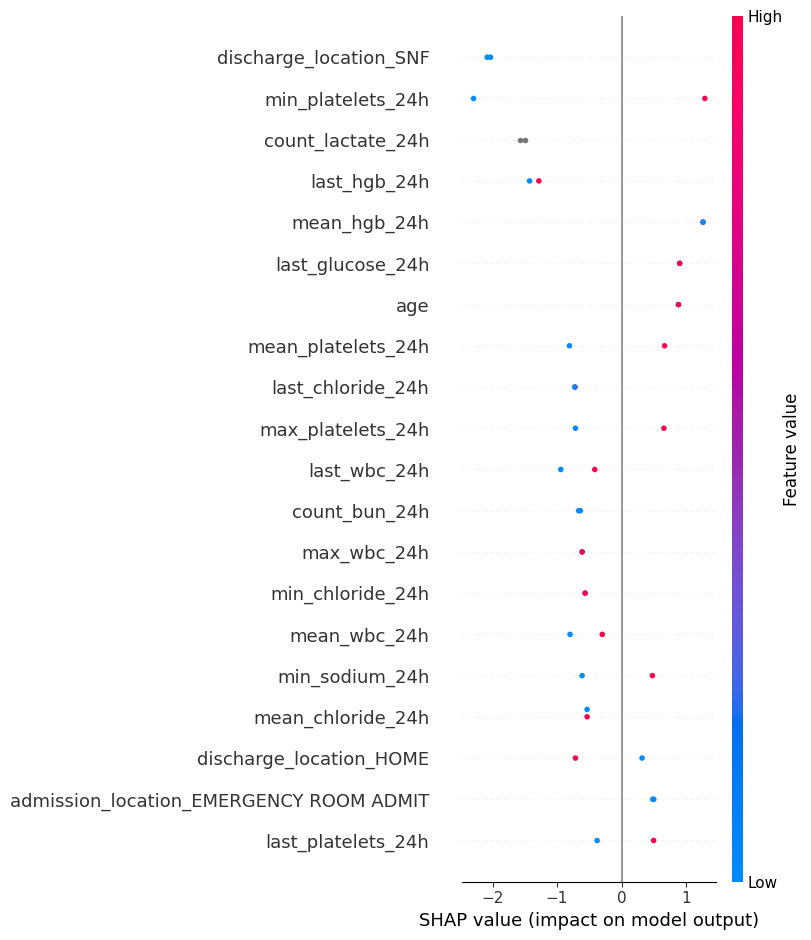

In [25]:
import matplotlib.pyplot as plt
# shap has its own plotting; this may open a figure inline
shap.summary_plot(shap_vals, X_te_mat, feature_names=feat_names, show=True)


In [27]:
# === REPLACEMENT FOR CELL J — SHAP for mortality classifier (pipeline-safe) ===
import numpy as np
import pandas as pd
import shap

# use the trained classifier pipeline 'clf' and the same train_df/test_df, feat_cols from Cell G
pre_c = clf.named_steps["pre"]
lr    = clf.named_steps["lr"]

# Get transformed matrices
X_tr_cls = pre_c.transform(train_df[feat_cols])
X_te_cls = pre_c.transform(test_df[feat_cols])
y_te_cls = test_df["label_mortality"].values

# Robust feature-name extraction from the ColumnTransformer (matches transformed columns 1:1)
try:
    feat_names_cls = pre_c.get_feature_names_out()
except Exception:
    # Fallback: build names manually if needed (rare)
    num_names = [f"num__{c}" for c in pre_c.transformers_[0][2]]
    # For cats, ask the OneHotEncoder
    ohe = pre_c.named_transformers_["cat"]
    cat_base = pre_c.transformers_[1][2]
    cat_exp  = ohe.get_feature_names_out(cat_base)
    feat_names_cls = np.concatenate([num_names, cat_exp])

# SHAP for linear models; convert sparse to dense if needed
X_tr_dense = X_tr_cls.toarray() if hasattr(X_tr_cls, "toarray") else X_tr_cls
X_te_dense = X_te_cls.toarray() if hasattr(X_te_cls, "toarray") else X_te_cls

expl = shap.LinearExplainer(lr, X_tr_dense)
shap_vals_cls = expl.shap_values(X_te_dense)  # shape: (n_samples, n_features)

# Ensure lengths line up; trim to the min if some transformers produced empty cols
n_feats = min(len(feat_names_cls), shap_vals_cls.shape[1])
feat_names_aligned = np.array(feat_names_cls)[:n_feats]
abs_mean_cls = np.mean(np.abs(shap_vals_cls[:, :n_feats]), axis=0)

imp_cls = (pd.DataFrame({"feature": feat_names_aligned, "mean_abs_shap": abs_mean_cls})
             .sort_values("mean_abs_shap", ascending=False)
             .head(30))
imp_cls


C:\Users\sarve\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['count_dbp_24h' 'count_sbp_24h' 'count_temp_24h' 'last_dbp_24h'
 'last_sbp_24h' 'last_temp_24h' 'max_dbp_24h' 'max_sbp_24h' 'max_temp_24h'
 'mean_dbp_24h' 'mean_sbp_24h' 'mean_temp_24h' 'min_dbp_24h' 'min_sbp_24h'
 'min_temp_24h' 'std_dbp_24h' 'std_sbp_24h' 'std_temp_24h']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\sarve\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['count_dbp_24h' 'count_sbp_24h' 'count_temp_24h' 'last_dbp_24h'
 'last_sbp_24h' 'last_temp_24h' 'max_dbp_24h' 'max_sbp_24h' 'max_temp_24h'
 'mean_dbp_24h' 'mean_sbp_24h' 

,feature,mean_abs_shap
38,num__mean_glucose_24h,0.341050
15,num__last_creatinine_24h,0.166633
48,num__min_creatinine_24h,0.166633
50,num__min_hgb_24h,0.157415
16,num__last_glucose_24h,0.156449
21,num__last_sodium_24h,0.154321
49,num__min_glucose_24h,0.124975
54,num__min_sodium_24h,0.120027
27,num__max_glucose_24h,0.119804
43,num__mean_sodium_24h,0.108319
